# ECON 4305 Project
# Data Cleaning

In [1]:
#Standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from pandas import read_csv
import time
sns.set(style='whitegrid', palette='muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

#Sklearn
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

import os  


In [2]:
# Imports raw data
macro = pd.read_excel('US FRED-MD Macro Dataset.xlsx', sheet_name=1,header=0, index_col=0)
macro.shape

(773, 127)

In [3]:
# Imports transformation code
tran_code = pd.read_excel('US FRED-MD Macro Dataset.xlsx', sheet_name=0, header=0, index_col=1, usecols=[1,2]).T
tran_code.shape

(1, 127)

In [4]:
# Define transformation for different variables
def data_transform(x, tran_code):
    
    if tran_code == 1:
        x_tr = x        
        
    elif tran_code == 2:
        x_tr = x.diff()
            
    elif tran_code == 3:
        x_tr = x.diff().diff()
        
    elif tran_code == 4:
        x_tr = np.log(x)
        
    elif tran_code == 5:
        x_tr = np.log(x).diff()*100
    
    elif tran_code == 6:
        x_tr = np.log(x).diff().diff()*100
    
    elif tran_code == 7:
        x_tr = (x.pct_change()-1)*100
    return x_tr    

In [5]:
#Construct the transformed dataframe
macro_tr=[]

for col in macro.columns:
    tr_code = tran_code[col].values
    data_tr = data_transform(macro[col], tr_code)
    macro_tr.append(data_tr)

macro_tr = pd.DataFrame(macro_tr).T

In [6]:
#Identify the features with most missing values

NA_list=[]
for i in macro_tr.columns:
    NA_list.append((i,macro_tr[i].isna().sum()))

NA_list.sort(reverse=True, key=lambda x:x[1])
NA_list

[('ACOGNO', 399),
 ('UMCSENTx', 229),
 ('TWEXAFEGSMTHx', 169),
 ('ANDENOx', 110),
 ('VIXCLSx', 42),
 ('PERMIT', 12),
 ('PERMITNE', 12),
 ('PERMITMW', 12),
 ('PERMITS', 12),
 ('PERMITW', 12),
 ('NONREVSL', 3),
 ('S&P div yield', 3),
 ('CP3Mx', 3),
 ('DTCOLNVHFNM', 3),
 ('DTCTHFNM', 3),
 ('CMRMTSPLx', 2),
 ('HWI', 2),
 ('HWIURATIO', 2),
 ('BUSINVx', 2),
 ('ISRATIOx', 2),
 ('M1SL', 2),
 ('M2SL', 2),
 ('BOGMBASE', 2),
 ('TOTRESNS', 2),
 ('BUSLOANS', 2),
 ('REALLN', 2),
 ('CONSPI', 2),
 ('S&P PE ratio', 2),
 ('WPSFD49207', 2),
 ('WPSFD49502', 2),
 ('WPSID61', 2),
 ('WPSID62', 2),
 ('OILPRICEx', 2),
 ('PPICMM', 2),
 ('CPIAUCSL', 2),
 ('CPIAPPSL', 2),
 ('CPITRNSL', 2),
 ('CPIMEDSL', 2),
 ('CUSR0000SAC', 2),
 ('CUSR0000SAD', 2),
 ('CUSR0000SAS', 2),
 ('CPIULFSL', 2),
 ('CUSR0000SA0L2', 2),
 ('CUSR0000SA0L5', 2),
 ('PCEPI', 2),
 ('DDURRG3M086SBEA', 2),
 ('DNDGRG3M086SBEA', 2),
 ('DSERRG3M086SBEA', 2),
 ('CES0600000008', 2),
 ('CES2000000008', 2),
 ('CES3000000008', 2),
 ('INVEST', 2),
 ('RPI', 

In [7]:
# Define inflation rate as the first difference of logarithms of CPIAUCSL
Inflation = np.log(macro["CPIAUCSL"]).diff()*100

In [14]:
# Remove columns with missing value
macro_final_d = pd.concat([macro_tr, Inflation], axis=1)
macro_final_d.columns=[*macro_tr.columns,"Inflation"]
macro_final_d=macro_final_d.drop(["1959-01-01"]).drop(labels=["ACOGNO","UMCSENTx","TWEXAFEGSMTHx","ANDENOx"],axis=1).fillna(method="ffill").dropna()
macro_final_d.shape

(731, 124)

In [9]:
# Remove data instances with missing value
macro_final = pd.concat([macro_tr, Inflation], axis=1)
macro_final.columns=[*macro_tr.columns,"Inflation"]
macro_final=macro_final.drop(["1959-01-01"]).fillna(method="ffill").dropna()
macro_final.shape

(375, 128)

In [10]:
# Show rows and columns
print("Rows, Columns:");print(macro_final.shape);print("\n")

# Describe DataFrame columns
print("Columns:");print(macro_final.columns);print("\n")

# Show info on DataFrame
print("Info:");print(macro_final.info(max_cols=1000)); print("\n")

# Count Non-NA values
print("Non-NA:");print(macro_final.count()); print("\n")

# Show head
print("Head");print(macro_final.head()); print("\n")

# Show tail
print("Tail");print(macro_final.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(macro_final.describe());print("\n")

Rows, Columns:
(375, 128)


Columns:
Index(['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'INDPRO',
       'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD',
       ...
       'DSERRG3M086SBEA', 'CES0600000008', 'CES2000000008', 'CES3000000008',
       'UMCSENTx', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'VIXCLSx',
       'Inflation'],
      dtype='object', length=128)


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 375 entries, 1992-01-03 to 2023-01-05
Data columns (total 128 columns):
 #    Column           Non-Null Count  Dtype  
---   ------           --------------  -----  
 0    RPI              375 non-null    float64
 1    W875RX1          375 non-null    float64
 2    DPCERA3M086SBEA  375 non-null    float64
 3    CMRMTSPLx        375 non-null    float64
 4    RETAILx          375 non-null    float64
 5    INDPRO           375 non-null    float64
 6    IPFPNSS          375 non-null    float64
 7    IPFINAL          375 non-null    float64
 8    IPCONGD       

              RPI     W875RX1  DPCERA3M086SBEA   CMRMTSPLx     RETAILx  \
count  375.000000  375.000000       375.000000  375.000000  375.000000   
mean     0.215520    0.202026         0.225666    0.190850    0.381480   
std      1.644681    0.784642         1.010070    1.214898    1.756461   
min    -14.565065   -6.056840       -12.799379  -12.889057  -15.809242   
25%      0.007161   -0.029388         0.023042   -0.263943   -0.100340   
50%      0.217967    0.244318         0.221694    0.211416    0.391249   
75%      0.421696    0.466747         0.448083    0.735339    0.913302   
max     18.234919    4.012112         8.208242    7.732231   17.405309   

           INDPRO     IPFPNSS     IPFINAL     IPCONGD    IPDCONGD  ...  \
count  375.000000  375.000000  375.000000  375.000000  375.000000  ...   
mean     0.135688    0.097974    0.105765    0.067255    0.168305  ...   
std      1.090312    1.113078    1.233082    1.147343    4.052974  ...   
min    -14.365634  -14.656939  -15.70

In [31]:
#Define Data for Machine Learning

X_start = 1  
X_lag = 1

# Features X and Target variable y
X, y = macro_final.iloc[X_start:-X_lag,:-1], macro_final.iloc[X_start+X_lag:,127]
X_d, y_d = macro_final_d.iloc[X_start:-X_lag,:-1], macro_final_d.iloc[X_start+X_lag:,-1]

In [32]:
X

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1992-01-04,0.373032,0.275060,0.083938,0.664201,0.601652,0.769184,0.748975,0.760298,0.940532,1.843950,...,-0.215571,0.077728,0.083014,-0.583570,0.175899,1.2,3.714687,-0.584329,0.134978,16.1885
1992-01-05,0.532885,0.549297,0.514589,-0.873850,0.546742,0.324748,0.546363,0.580914,0.647050,3.074505,...,0.097556,-0.255295,-0.251432,-0.072648,-0.088998,2.0,-5.294144,0.020679,0.410802,14.7280
1992-01-06,0.417254,0.444719,0.269590,1.048664,0.280383,0.059695,-0.239920,-0.304895,-0.484071,-1.398611,...,0.318864,0.023712,0.250035,0.795664,-0.088298,1.2,4.562073,0.881246,-0.087417,14.7531
1992-01-07,-0.079646,-0.134642,0.334203,1.330298,0.708002,0.893837,0.995847,1.126762,1.294361,2.614598,...,-0.233369,0.264845,-0.416910,-1.518733,-0.000307,-3.8,-0.352309,-0.854378,0.216749,13.3036
1992-01-08,0.386454,0.380539,0.246840,-1.603560,0.324124,-0.549192,-0.106279,-0.111965,0.036867,-0.863906,...,-0.032213,-0.285966,0.499100,1.157537,0.086992,-0.5,-0.633643,1.163376,0.042164,14.4223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-12,-0.013781,-0.019171,-0.193846,1.490076,-0.719328,-1.550613,-1.202485,-0.846966,-0.623823,-1.031771,...,-0.613838,0.175427,-0.107940,0.300155,-0.590025,2.9,-0.283245,-0.123254,0.880929,21.7702
2023-01-01,0.087570,0.130699,1.316033,0.190398,2.764501,1.003181,0.343776,-0.014901,-0.334291,0.217564,...,1.425376,0.033243,0.170724,-0.004386,0.309575,5.2,0.071035,0.049043,-0.142513,20.2269
2023-01-02,0.103913,-0.004103,-0.028459,-0.417590,-0.660515,-0.005561,-0.196666,-0.129562,0.097723,0.212525,...,-0.416042,-0.224790,-0.417543,-0.152983,-0.621376,2.1,-0.237727,-0.068985,-0.121427,20.2141


In [33]:
y

sasdate
1992-01-05    0.214977
1992-01-06    0.285919
1992-01-07    0.285104
1992-01-08    0.213295
1992-01-09    0.212842
                ...   
2023-01-01    0.515742
2023-01-02    0.369323
2023-01-03    0.053028
2023-01-04    0.367109
2023-01-05    0.124049
Name: Inflation, Length: 373, dtype: float64

In [19]:
# output the preprocessed data as csv file
import os  
os.makedirs('Data preprocess', exist_ok=True)  
# data instances with missing values are removed
X.to_csv('Data preprocess/x.csv') 
y.to_csv('Data preprocess/y.csv')

# data features with missing values are removed
X_d.to_csv('Data preprocess/x_columns_removed.csv') 
y_d.to_csv('Data preprocess/y_columns_removed.csv')


# Data Explore

<Axes: title={'center': 'Correlation with Inflation rate'}>

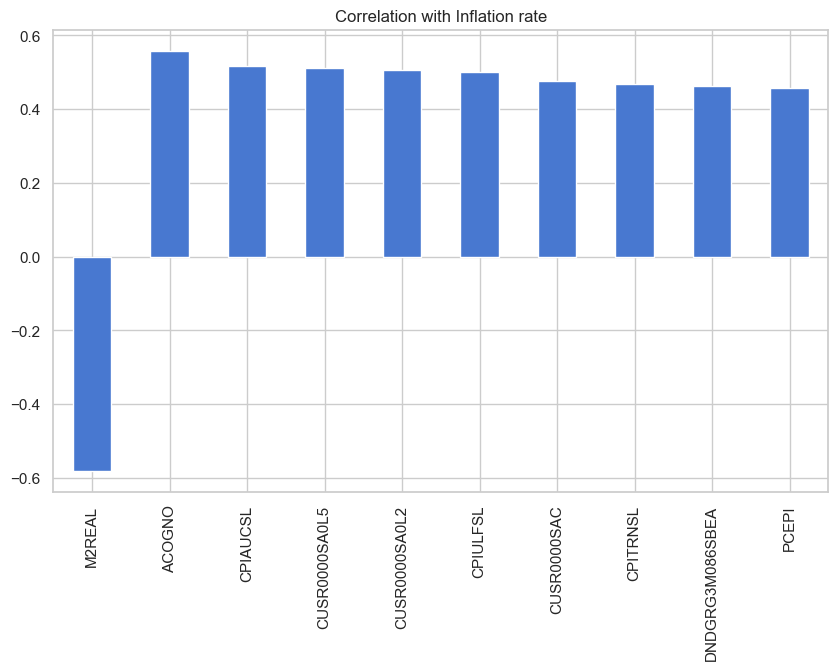

In [34]:
#Correlation of features with inflation rate
corr=X.corrwith(y)
#corr=corr.apply(abs)
corr=corr.sort_values(key=lambda x:abs(x), ascending=False)

corr.iloc[:10].plot.bar(figsize = (10, 6), title = "Correlation with Inflation rate", grid = True)


A preliminary analysis on our data have shown the following top 10 features that have highest correlation with inflation rate

Real M2 Money Stock (negative correlation)

New Orders for Consumer Goods

CPI : All Items

CPI : All items less medical care

CPI : All items less shelter

CPI : All Items Less Food

CPI : Commodities

CPI : Transportation

Personal Cons. Expenditure: Nondurable goods


<function matplotlib.pyplot.show(close=None, block=None)>

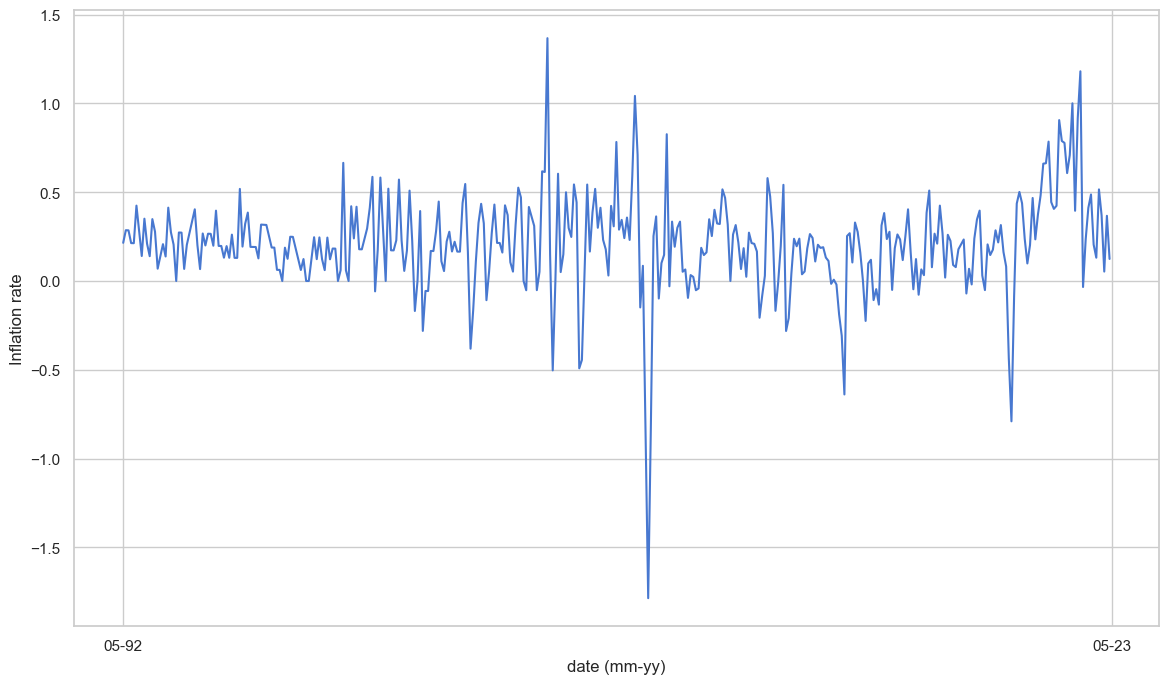

In [35]:
# Inflation rate from May 1992 to May 2023
X=pd.read_csv("Data preprocess/x.csv",header=0, index_col=0)
y=pd.read_csv("Data preprocess/y.csv",header=0, index_col=0)
plt.plot(y)
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.xticks([0,373],["05-92","05-23"])
plt.show

There is not a obvious trend for inflation rate over time

# Principal Component Analysis (PCA)

In [27]:
steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
           ('pca', PCA(n_components = 1, random_state=1))]

pl_pca_X = Pipeline(steps_X)

X_pca_model = pl_pca_X.fit(X)

print('n_components:', 1, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

X_pca = X_pca_model.transform(X)

n_components: 1    variance explained: 0.223


In [29]:
n=[]
var_explained=[]
for n_comp in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,50,100,120,127]:

    steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = n_comp, random_state=1))]
    
    pl_pca_X = Pipeline(steps_X)
    X_pca_model = pl_pca_X.fit(X)
    n.append(n_comp)
    var_explained.append(X_pca_model.steps[1][1].explained_variance_ratio_.sum())
    print('n_components:', n_comp, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())


n_components: 1    variance explained: 0.223
n_components: 2    variance explained: 0.313
n_components: 3    variance explained: 0.390
n_components: 4    variance explained: 0.450
n_components: 5    variance explained: 0.491
n_components: 6    variance explained: 0.527
n_components: 7    variance explained: 0.555
n_components: 8    variance explained: 0.580
n_components: 9    variance explained: 0.602
n_components: 10    variance explained: 0.623
n_components: 11    variance explained: 0.643
n_components: 12    variance explained: 0.661
n_components: 13    variance explained: 0.678
n_components: 14    variance explained: 0.695
n_components: 15    variance explained: 0.710
n_components: 16    variance explained: 0.723
n_components: 17    variance explained: 0.737
n_components: 18    variance explained: 0.749
n_components: 19    variance explained: 0.761
n_components: 20    variance explained: 0.773
n_components: 30    variance explained: 0.859
n_components: 50    variance explained: 0.9

Text(0.5, 1.0, 'Scree Plot')

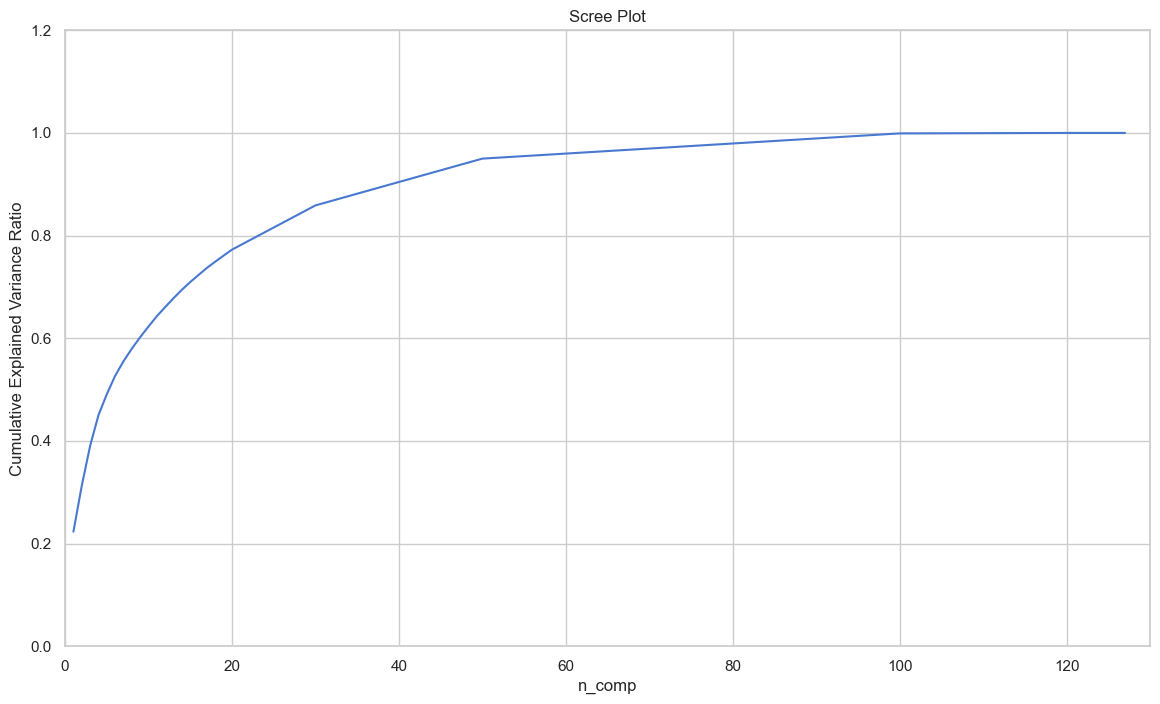

In [36]:
plt.plot(n, var_explained)
plt.xlabel("n_comp")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.axis([0,130,0,1.2])
plt.title('Scree Plot')

About 20 principal components from PCA can already explain 80% of the variance in the dataset

In [40]:
loadings = pl_pca_X[1].components_[:20]
loadings
# Calculate the average absolute loading for each feature
avg_loadings = np.abs(loadings).mean(axis=0)
# Sort the features based on their average loadings
sorted_indices = np.argsort(avg_loadings)[::-1]

# Print the relative importance of features
for feature_index in sorted_indices:
    print(f"Feature {feature_index} {X.columns[feature_index]}: {avg_loadings[feature_index]}")



Feature 59 ANDENOx: 0.10341936120580411
Feature 72 CONSPI: 0.10175646695987547
Feature 58 AMDMNOx: 0.10014089477007956
Feature 0 RPI: 0.09833476675564665
Feature 67 TOTRESNS: 0.09471048995804308
Feature 119 CES0600000008: 0.09470543247994738
Feature 10 IPNCONGD: 0.09406654758418459
Feature 16 IPB51222S: 0.09380240191266193
Feature 63 M1SL: 0.09170898237223904
Feature 27 UEMP15OV: 0.0910650050901426
Feature 110 CUSR0000SAD: 0.08989301423565683
Feature 60 AMDMUOx: 0.08528887690552524
Feature 116 DDURRG3M086SBEA: 0.08519877452414298
Feature 118 DSERRG3M086SBEA: 0.08506464355847929
Feature 84 AAA: 0.08427238270498197
Feature 65 M2REAL: 0.08329450095085013
Feature 121 CES3000000008: 0.0828333621434167
Feature 91 T10YFFM: 0.08202157161712695
Feature 94 TWEXAFEGSMTHx: 0.08194421331607575
Feature 85 BAA: 0.08185079450929093
Feature 111 CUSR0000SAS: 0.08165203477083668
Feature 124 DTCTHFNM: 0.08132531956969201
Feature 90 T5YFFM: 0.08084497257768729
Feature 83 GS10: 0.08062063727421752
Feature 7

In the first 20 principal componenets, New Orders for Nondefense Capital Goods, Nonrevolving consumer credit to Personal Income, New Orders for Durable Goods and Real Personal Income are the features with most loadings